[1407, 4972, 2111, 2798, 3218, 500, 6182, 1116, 1079, 986, 1064, 2404, 3251, 5031, 3225, 3344, 3205, 3979, 4313, 3907, 3956, 6492, 3491, 3204, 8715, 3377, 4477, 3152, 2368, 3847, 3708, 4919, 3827, 3727, 1497, 3476, 2717, 3454, 3750, 2697, 851, 3686, 3191, 5352, 1380, 2300, 3474, 2724, 2964, 3532, 3141, 4790, 3881, 3974, 4595]
[500, 851, 986, 1064, 1079, 1116, 1380, 1407, 1497, 2111, 2300, 2368, 2404, 2697, 2717, 2724, 2798, 2964, 3141, 3152, 3191, 3204, 3205, 3218, 3225, 3251, 3344, 3377, 3454, 3474, 3476, 3491, 3532, 3686, 3708, 3727, 3750, 3827, 3847, 3881, 3907, 3956, 3974, 3979, 4313, 4477, 4595, 4790, 4919, 4972, 5031, 5352, 6182, 6492, 8715]


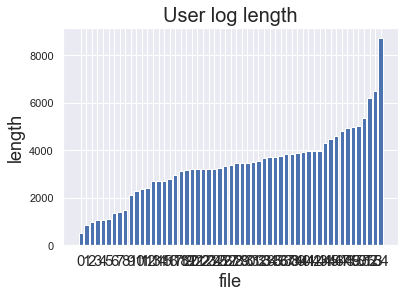

(55, 6492, 2)
[[[0.98328788 0.90362   ]
  [0.98295443 0.90378679]
  [0.98258283 0.90398083]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.03809905 0.11438292]
  [0.03778963 0.11538551]
  [0.03752254 0.11633642]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.60835409 0.78063051]
  [0.60869958 0.78115104]
  [0.60920595 0.78161753]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 ...

 [[0.06671002 0.01100964]
  [0.06652521 0.01166505]
  [0.06643671 0.01239972]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.06217145 0.01526194]
  [0.06187603 0.01568926]
  [0.06158928 0.01619516]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.56212699 0.77853316]
  [0.56250525 0.77734883]
  [0.56275076 0.77566991]
  ...
  [0.         0.        ]
  [0.         0.        ]
  [0.         0.        

In [15]:
## 사용자의 log 분석
original_df = []
scaled_df = []
scaler = MinMaxScaler()

# 모든 사용자 load
users = ['0mnEB226qqgHE79KLEfxRj6fiEK2']

for user in users:
    #print(user)
    original_list = []
    scaled_list = []
    len_list = []

    # log_info/user 폴더 하위에 있는 모든 파일에 대해 (즉, 모든 log파일에 대해) 도로 세그먼트 정보를 생성
    for file in listdir('./log_segment_info/'+user):
        log_name = file.split("_")[0]

        # log{logname}_info.csv 파일을 load
        log_csv_name= './log_segment_info/'+user+"/"+file
        if('segment' not in file):
            continue
            
        #print(log_csv_name)
        if os.path.isfile(log_csv_name):
            csv = pd.read_csv(log_csv_name, usecols=['mercX', 'mercY'])
            if len(csv) == 0:
                print("log length is 0")
                continue
                
            # segment matching이 실패한 행 제외
            #csv = csv[csv['seg_id'].notnull()]
            
            # 정규화
            scaled_csv = scaler.fit_transform(csv)
            
            original_list.append(csv.values.tolist())
            scaled_list.append(scaled_csv)
            len_list.append(len(csv))
        else:
            print("no log info")

    print(len_list)
    


    # 최대 길이 선택
    selected_length = 6492

    # padding 추가
    original_df = pad_sequences(original_list, padding='post', maxlen=selected_length, dtype='float64')
    scaled_df = pad_sequences(scaled_list, padding='post', maxlen=selected_length, dtype='float64')
    print(scaled_df.shape)
    print(scaled_df)

In [6]:
# #Autoencoder network model 정의
# return_sequences=True: decoder의 input에 encoder의 모든 output이 각각 사용됨
# RepeadVector: decoder의 input에 encoder의 제일 마지막 output만 사용됨

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    masked = Masking(mask_value=0.)(inputs)
    encoder_1 = LSTM(64, activation='relu', return_sequences=False)(masked)
    encoded_feature = RepeatVector(X.shape[1])(encoder_1)
    decoder_1 = LSTM(64, activation='relu', return_sequences=True)(encoded_feature)
    output = TimeDistributed(Dense(X.shape[2]))(decoder_1)
    model = Model(inputs=inputs, outputs=output)
    return model

In [7]:
# 학습
X_train = scaled_df
print(X_train.shape)
 
model = autoencoder_model(X_train)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['acc'])
model.summary()

(55, 6492, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6492, 2)]         0         
                                                                 
 masking (Masking)           (None, 6492, 2)           0         
                                                                 
 lstm (LSTM)                 (None, 6492, 128)         67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 6492, 64)         0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 6492, 64)          33024     
                                               

In [8]:
## n회 반복
nb_epochs = 100
batch_size = 20
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Epoch 1/100
3/3 [==============================] - 262s 89s/step - loss: 0.2576 - acc: 0.4234 - val_loss: 0.3262 - val_acc: 0.5257
Epoch 2/100
3/3 [==============================] - 550s 181s/step - loss: 0.2573 - acc: 0.4337 - val_loss: 0.3259 - val_acc: 0.4716
Epoch 3/100


KeyboardInterrupt: 

In [ ]:
## 모델의 예측값 확인
print(X_train.shape)
yhat = model.predict(X_train, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X_train, 3))

## 모델 평가하기
loss_and_metrics = model.evaluate(X_train, X_train, batch_size=batch_size)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)